In [84]:
#plots
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#interactive plots
import chart_studio.plotly as py
import plotly.graph_objs as go 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
init_notebook_mode(connected=True)
cf.go_offline()
import plotly.graph_objs as go 
from plotly.offline import init_notebook_mode,iplot 

#Machine Learning Basics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
scala=StandardScaler()

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import re
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot, Tokenizer

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout, Flatten, Embedding
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

import gensim
from gensim.models.phrases import Phraser, Phrases
from gensim.models.word2vec import Word2Vec
from sklearn.manifold import TSNE

In [85]:
df=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

In [86]:
df.head(6)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1


In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [88]:
#After seeing the amount of null values, I start checking what are the non-nan values for the column keyword
#I skip the describe part having seen that the two numerical values are the id, which gives us no real information, and the target, which by definition is not what we are going to base our evaluation on
df[~df.keyword.isna()].head(6)

,id,keyword,location,text,target
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0
36,54,ablaze,Pretoria,@PhDSquares #mufc they've built so much hype a...,0


In [89]:
#I start checking the number of different unique values for that column, and I see that there are over two hundred different ones
df.keyword.value_counts()

fatalities               45
deluge                   42
armageddon               42
harm                     41
sinking                  41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

In [90]:
#I do a similar check. I see that there are many more unique types, with over 2000 of them being unique values
"""
The location the tweet came from can be surely relevant, allowing use to cross-reference geological datas and such to look for disaster. 
However, not only we have no way to do so here, that would also mean basically knowing what is happening and defeat the purpose of learning it through the tweets themselves.
Hence, I decide to just drop the column
"""
df.location.value_counts().tail(3000)

El Dorado, Arkansas         2
Redding, California, USA    2
Ewa Beach, HI               2
Dubai                       2
Somalia                     2
                           ..
Viejo                       1
???????? ?????????.         1
St. Louis, Mo               1
Nashua NH                   1
Jersey Shore                1
Name: location, Length: 3000, dtype: int64

In [91]:
#I decide to add a column to check the message lenght and do some preliminary exploration
df=df.drop('location', axis=1)

In [92]:
df['len']=df.text.apply(len)

<AxesSubplot:xlabel='target', ylabel='len'>

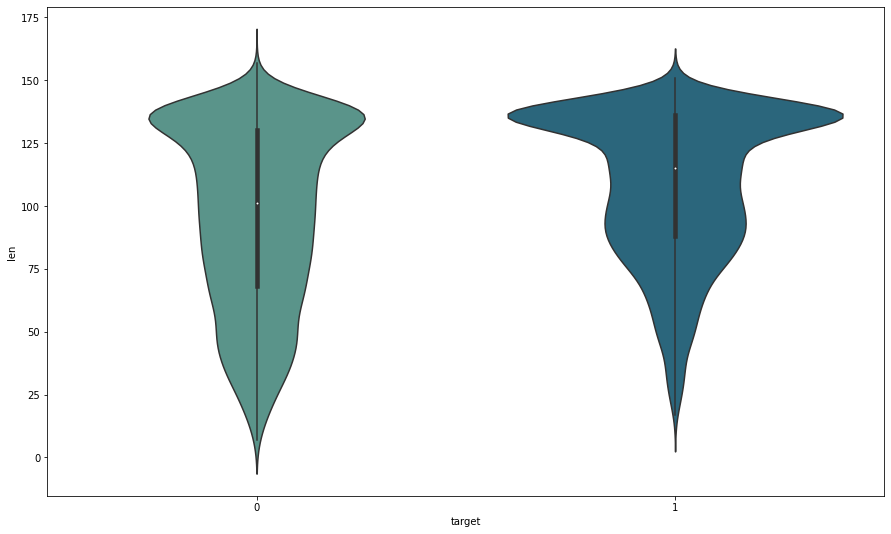

In [93]:
plt.figure(figsize=(15,9))
sns.violinplot(data=df,y='len', x='target', palette='crest', split=True)
#We notice that tweets seem to be longer when describing actual danger. It makes sense: they need to explain what it happening

<AxesSubplot:xlabel='len', ylabel='count'>

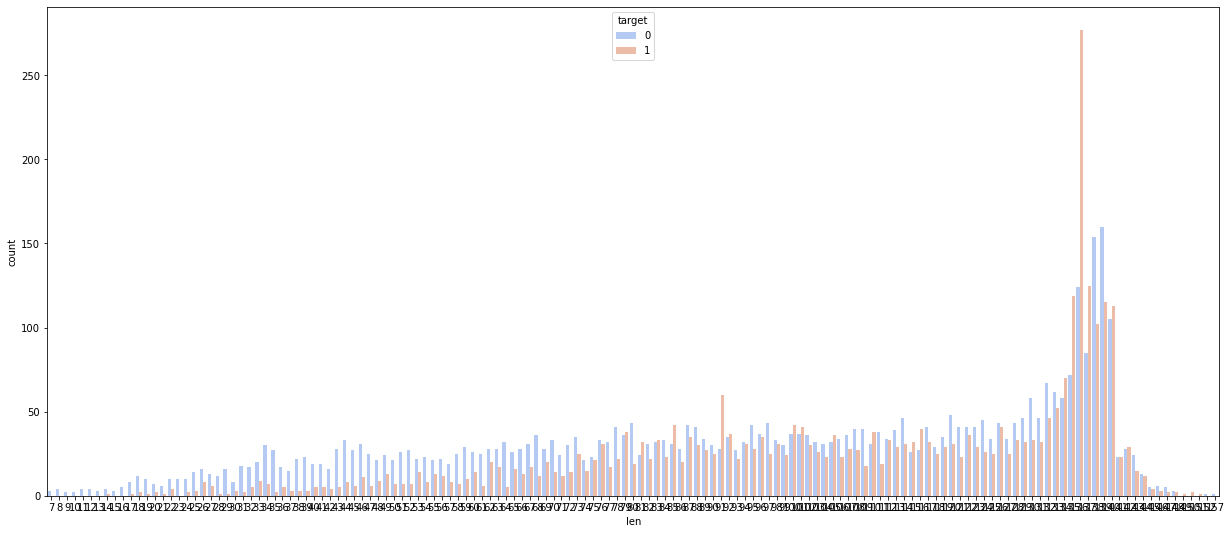

In [94]:
plt.figure(figsize=(21,9))
sns.countplot(data=df,x='len', hue='target', palette='coolwarm')
#This gives more context, despite the unclear bar: it's rare to have short alert tweets, but they are almost as likely from tweets of lenght>100, with a weird spike around 136

In [95]:
df.groupby('target').describe().transpose()

target                0             1
id  count   4342.000000   3271.000000
    mean    5276.446338   5661.608071
    std     3157.206802   3097.094809
    min       23.000000      1.000000
    25%     2513.250000   3104.500000
    50%     5243.500000   5676.000000
    75%     8038.500000   8252.000000
    max    10848.000000  10873.000000
len count   4342.000000   3271.000000
    mean      95.706817    108.113421
    std       35.885924     29.309854
    min        7.000000     14.000000
    25%       68.000000     88.000000
    50%      101.000000    115.000000
    75%      130.000000    136.000000
    max      157.000000    151.000000

In [96]:
#It was worth checking, but apparently length won't help. The keywords will also be considered already in our model by valuing the words, so we drop that column as well
#So now we try to clean up the text
# clean text from noise
def clean_text(text):
    # filter to allow only alphabets
    text = re.sub(r'[^a-zA-Z\']', ' ', text)
    
    # remove Unicode characters
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    
    # convert to lowercase to maintain consistency
    text = text.lower()
    text=text.split()
       
    return text

In [97]:
df['text'].head(6).apply(clean_text)

0    [our, deeds, are, the, reason, of, this, earth...
1        [forest, fire, near, la, ronge, sask, canada]
2    [all, residents, asked, to, 'shelter, in, plac...
3    [people, receive, wildfires, evacuation, order...
4    [just, got, sent, this, photo, from, ruby, ala...
5    [rockyfire, update, california, hwy, closed, i...
Name: text, dtype: object

In [98]:
#Now that we have defined out analyzer clean_text, we can create a pipeline to construct our initial model
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=clean_text)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [99]:
#Taken care of this, we can do our train/test split, fit the pipeline on the training data and test the predictions of our model
X_train, X_test, y_train, y_test=train_test_split(df['text'], df['target'], random_state=102, test_size=0.18)
pipeline.fit(X_train,y_train)
predictions=pipeline.predict(X_test)

In [100]:
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test,predictions))

              precision    recall  f1-score   support

           0       0.75      0.94      0.84       755
           1       0.89      0.62      0.73       616

    accuracy                           0.80      1371
   macro avg       0.82      0.78      0.78      1371
weighted avg       0.82      0.80      0.79      1371

[[709  46]
 [234 382]]


In [207]:
#We define the tokenizer on the number of individual songs found, 22867 and pad the text
tokenizer = Tokenizer(num_words=22867)
tokenizer.fit_on_texts(df['text'])
encoded_post = tokenizer.texts_to_sequences(df['text'])
X=pad_sequences(encoded_post, maxlen=157, padding='post')

X_train, X_validation, y_train, y_validation=train_test_split(X, df['target'], random_state=102, test_size=0.18)


'''
X_train, X_validation, y_train, y_validation=train_test_split(df['text'], df['target'], random_state=102, test_size=0.18)

#We define the tokenizer on the number of individual songs found, 22867
tokenizer = Tokenizer(num_words=22867)

#We pad X_train and X_validation. We do the tokenizer fits individually to avoid data contamination
tokenizer.fit_on_texts(X_train)
encoded_train = tokenizer.texts_to_sequences(X_train)
X_train=pad_sequences(encoded_train, maxlen=157, padding='post')


tokenizer = Tokenizer(num_words=22867)
tokenizer.fit_on_texts(X_validation)
encoded_validation = tokenizer.texts_to_sequences(X_train)
X_validation=pad_sequences(encoded_validation, maxlen=157, padding='post')
'''



"\nX_train, X_validation, y_train, y_validation=train_test_split(df['text'], df['target'], random_state=102, test_size=0.18)\n\n#We define the tokenizer on the number of individual songs found, 22867\ntokenizer = Tokenizer(num_words=22867)\n\n#We pad X_train and X_validation. We do the tokenizer fits individually to avoid data contamination\ntokenizer.fit_on_texts(X_train)\nencoded_train = tokenizer.texts_to_sequences(X_train)\nX_train=pad_sequences(encoded_train, maxlen=157, padding='post')\n\n\ntokenizer = Tokenizer(num_words=22867)\ntokenizer.fit_on_texts(X_validation)\nencoded_validation = tokenizer.texts_to_sequences(X_train)\nX_validation=pad_sequences(encoded_validation, maxlen=157, padding='post')\n"

In [208]:

#Now we try creating asequential model


model = Sequential()
#We calculated that there are 22867 unique words and embed them in a 128-dimensional space
model.add(Embedding(22867, 128, input_length=157))
model.add(Flatten())

#Input layer
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.3))

#Hidden layer 1
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.3))

#Hidden layer 2
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

#Hidden layer 3
model.add(Dense(units=8, activation='relu'))
model.add(Dropout(0.3))

#Output
model.add(Dense(units=1, activation='sigmoid'))

#Compile
model.compile(optimizer='adam', loss='binary_crossentropy')

In [209]:
#model.fit(x=X_train,y=y_train, verbose=3,epochs=24, batch_size=256, validation_data=(X_validation,y_validation))

earlyStop=EarlyStopping(monitor='val_loss',mode='min',verbose=3,patience=1)
model.fit(x=X_train,y=y_train, verbose=3,epochs=60, batch_size=256, validation_data=(X_validation,y_validation), callbacks=[earlyStop])

Epoch 1/60
Epoch 2/60
Epoch 3/60
Epoch 4/60
Epoch 5/60
Epoch 00005: early stopping


In [210]:
first_losses=pd.DataFrame(model.history.history)
first_losses.iplot()

In [211]:
predictions = (model.predict(X_validation) > 0.5).astype("int32")
y_pred = model.predict(X_validation)
y_pred = np.round(y_pred).astype(int)

In [212]:
print(classification_report(y_validation,predictions))
print('\n')
print(confusion_matrix(y_validation,predictions))
print(classification_report(y_validation,y_pred))
print('\n')
print(confusion_matrix(y_validation,y_pred))

              precision    recall  f1-score   support

           0       0.78      0.88      0.83       755
           1       0.82      0.70      0.76       616

    accuracy                           0.80      1371
   macro avg       0.80      0.79      0.79      1371
weighted avg       0.80      0.80      0.80      1371



[[661  94]
 [182 434]]
              precision    recall  f1-score   support

           0       0.78      0.88      0.83       755
           1       0.82      0.70      0.76       616

    accuracy                           0.80      1371
   macro avg       0.80      0.79      0.79      1371
weighted avg       0.80      0.80      0.80      1371



[[661  94]
 [182 434]]
